# 02 网络拓扑与 ABM 验证

本 notebook **默认先做“基准验证”**：设置 `beta=0`（无邻居耦合）+ `sample_mode="fixed"`，让网络 ABM 退化为 well-mixed 近似，用于对齐并验证理论临界点 `r_c` 与对称分岔（Symmetric）。

当且仅当 `beta>0` 和/或 `sample_mode="degree"` 时，网络结构（ER/BA、平均度 ⟨k⟩）才会显著影响动力学；这部分属于“拓扑效应”扩展，本 notebook 暂不默认开启（避免把拓扑效应与基准验证混在一起）。

约定：
- `k_avg`：理论中“每个体每步采样的信号数量”
  - `sample_mode="fixed"`：`k_avg = sample_n`
  - `sample_mode="degree"`：`k_avg ≈ ⟨k⟩`（近似为网络平均度）
- `Theory r_c` 仅对 **对称模式**（`symmetric_mode=True`）且 `k_avg` 口径一致时可严格对比；非对称模式中绘制的 `r_c` 仅作为参考线。


In [6]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep")

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import theory, NetworkConfig, NetworkAgentModel

output_dir = ROOT / "outputs"
output_dir.mkdir(exist_ok=True)

data_dir = output_dir / "data"
fig_dir = output_dir / "figs" / "fig2"
data_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

def fmt_path(path: Path) -> str:
    try:
        return path.relative_to(ROOT).as_posix()
    except ValueError:
        return path.as_posix()

phi, theta = 0.54, 0.46
TARGET_SAMPLE_N = 50  # 理论/模拟统一采样数
n_m, n_w = 10, 5

chi_ref = theory.calculate_chi(phi, theta, k_avg=TARGET_SAMPLE_N)
rc_ref = float(theory.calculate_rc(n_m, n_w, chi_ref))
print(f"Theory Reference (Symmetric, k_avg={TARGET_SAMPLE_N}): chi={chi_ref:.4f}, rc={rc_ref:.4f}  (sample_mode=fixed)")


Theory Reference (Symmetric, k_avg=50): chi=9.5962, rc=0.7533  (sample_mode=fixed)


In [7]:
# 理论 r_c 对比：k_avg=50（与 sample_n 对齐） vs k_avg=1999（高采样上限示例）
chi_50 = theory.calculate_chi(phi, theta, k_avg=50)
rc_50 = float(theory.calculate_rc(n_m, n_w, chi_50))
chi_1999 = theory.calculate_chi(phi, theta, k_avg=1999)
rc_1999 = float(theory.calculate_rc(n_m, n_w, chi_1999))
print(f"Theory r_c (k_avg=50):   {rc_50:.4f}")
print(f"Theory r_c (k_avg=1999): {rc_1999:.4f}")
if rc_1999 > 1:
    print("提示：r_c>1 表示在 r∈[0,1] 内不会越过临界点（该 k_avg 口径下）。")


Theory r_c (k_avg=50):   0.7533
Theory r_c (k_avg=1999): 1.7859
提示：r_c>1 表示在 r∈[0,1] 内不会越过临界点（该 k_avg 口径下）。



## 02a 对称模式 (Symmetric)


[sym] Simulating ABM scans... (k_avg=50 (fixed), ER ⟨k⟩=50, β=0.0, update=0.1)
[sym] Saved cache: outputs/data/rq_a_scan_sym_N500_er_k50_fixed50_beta0.0_u10_ri10_burn50_seeds10_steps300_v3.npz


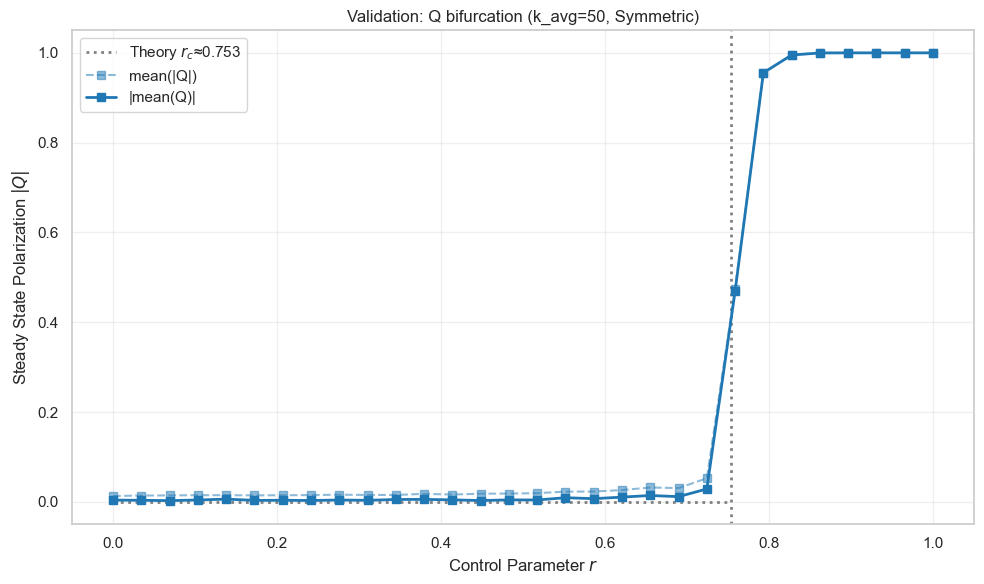

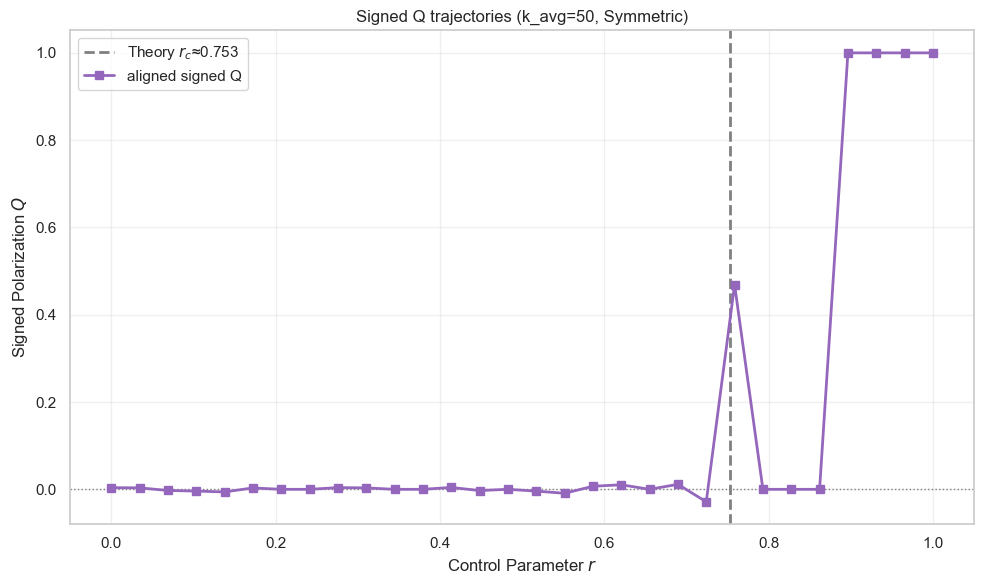

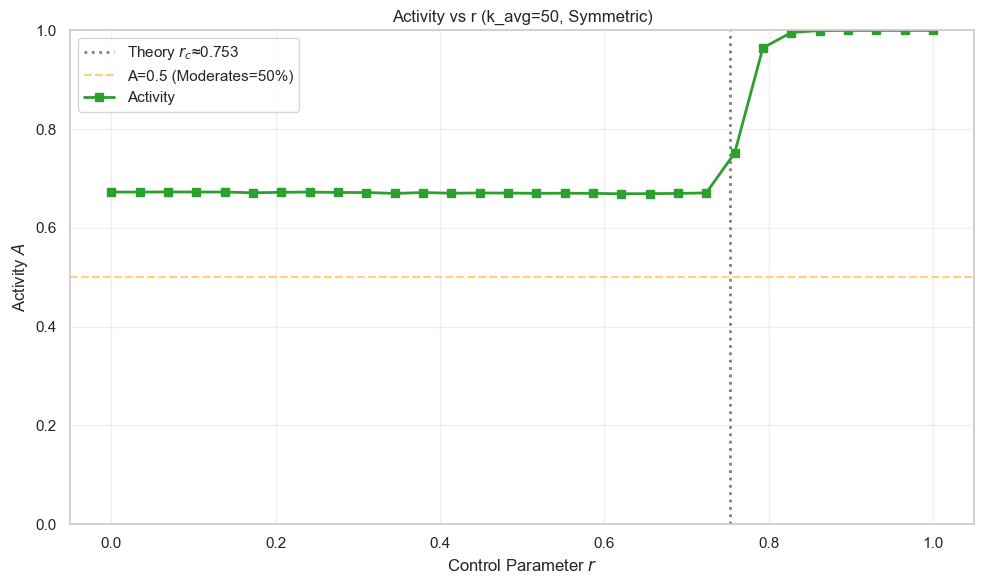

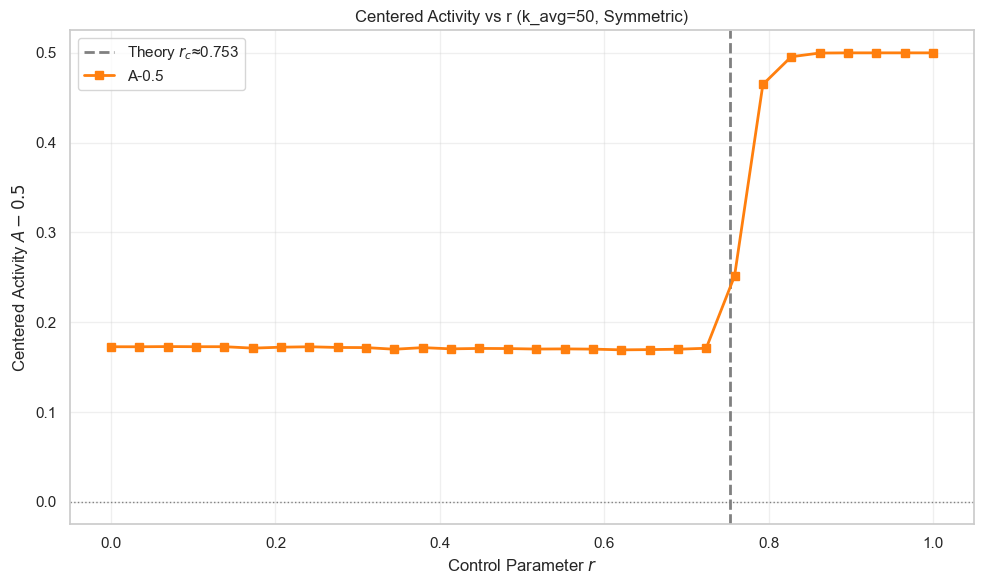

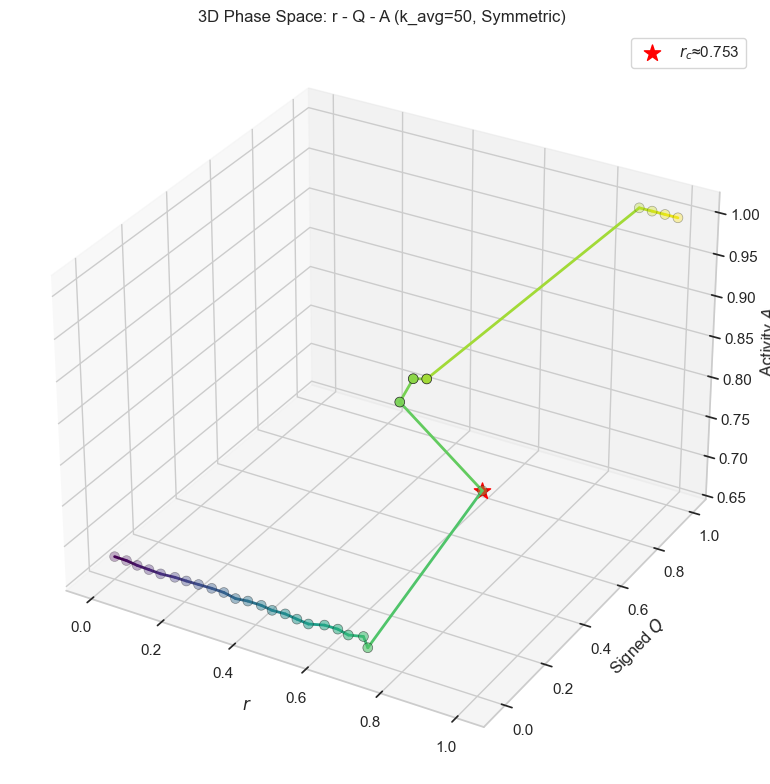

In [8]:
# 共用：ABM 扫描与绘图（对称 / 非对称）
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# -----------------------------
# 实验口径（默认：基准验证）
# -----------------------------
# 说明：
# - beta=0 时，每个体只受全局 p_env 影响，网络拓扑不会进入动力学（仍会生成网络但不影响结果）
# - sample_mode="fixed" 时，理论中的 k_avg 与模拟中的 sample_n 一致
N = 500
NETWORK_MODEL = "er"
AVG_DEGREE = 50
SAMPLE_MODE = "fixed"
SAMPLE_N = TARGET_SAMPLE_N

BETA = 0.0
UPDATE_RATE = 0.1
INIT_STATE = "medium"

R_SCAN = np.linspace(0, 1.0, 30)
SEEDS = list(range(10))
STEPS = 300
RECORD_INTERVAL = 10
BURN_IN_FRAC = 0.5  # 丢弃前 50% 作为 burn-in

CFG_TAG = f"{NETWORK_MODEL}_k{AVG_DEGREE}_{SAMPLE_MODE}{SAMPLE_N}_beta{BETA}_u{int(UPDATE_RATE*100)}"
CFG_LABEL = f"k_avg={SAMPLE_N} ({SAMPLE_MODE}), {NETWORK_MODEL.upper()} ⟨k⟩={AVG_DEGREE}, β={BETA}, update={UPDATE_RATE}"


def _cache_path(mode_tag: str) -> Path:
    burn = int(BURN_IN_FRAC * 100)
    cache_name = (
        f"rq_a_scan_{mode_tag}_N{N}_{CFG_TAG}_"
        f"ri{RECORD_INTERVAL}_burn{burn}_seeds{len(SEEDS)}_steps{STEPS}_v3.npz"
    )
    return data_dir / cache_name


def run_abm_scan(symmetric_mode: bool, mode_tag: str):
    cache_path = _cache_path(mode_tag)

    if cache_path.exists():
        loaded = np.load(cache_path)
        res = {k: loaded[k] for k in ["mean_abs", "abs_mean", "signed_mean", "a_mean", "a_signed"]}
        print(f"[{mode_tag}] Loaded cache: {fmt_path(cache_path)}")
        return loaded["r_scan"], res

    print(f"[{mode_tag}] Simulating ABM scans... ({CFG_LABEL})")
    burn_step = STEPS * BURN_IN_FRAC

    mean_abs, abs_mean, signed_mean = [], [], []
    a_mean, a_signed = [], []

    for r in R_SCAN:
        q_mean_abs_seeds, q_abs_mean_seeds, q_mean_seeds = [], [], []
        a_mean_seeds, a_signed_seeds = [], []

        for seed in SEEDS:
            net_cfg = NetworkConfig(
                n=N,
                avg_degree=AVG_DEGREE,
                model=NETWORK_MODEL,
                beta=BETA,
                update_rate=UPDATE_RATE,
                r=r,
                n_m=n_m,
                n_w=n_w,
                phi=phi,
                theta=theta,
                seed=seed,
                init_state=INIT_STATE,
                sample_mode=SAMPLE_MODE,
                sample_n=SAMPLE_N,
                symmetric_mode=symmetric_mode,
            )
            model = NetworkAgentModel(net_cfg)
            t, q_traj, a_traj = model.run(steps=STEPS, record_interval=RECORD_INTERVAL)

            steady_mask = t >= burn_step
            steady_q = q_traj[steady_mask]
            steady_a = a_traj[steady_mask]

            q_mean = float(np.mean(steady_q))
            q_mean_abs_seeds.append(float(np.mean(np.abs(steady_q))))
            q_abs_mean_seeds.append(float(abs(q_mean)))
            q_mean_seeds.append(q_mean)
            a_mean_seeds.append(float(np.mean(steady_a)))
            a_signed_seeds.append(float(np.mean(steady_a - 0.5)))

        mean_abs.append(np.mean(q_mean_abs_seeds))
        abs_mean.append(np.mean(q_abs_mean_seeds))

        # 对称性破缺处理（用于可视化 signed 分支）：
        # 用 seeds 的“时间均值符号”做多数投票；若正负打平，则 sign=0（避免偏置）。
        sign_sum = np.sum(np.sign(q_mean_seeds))
        majority_sign = 1.0 if sign_sum > 0 else (-1.0 if sign_sum < 0 else 0.0)
        signed_mean.append(majority_sign * abs_mean[-1])

        a_mean.append(np.mean(a_mean_seeds))
        a_signed.append(np.mean(a_signed_seeds))

    res = {
        "mean_abs": np.asarray(mean_abs, dtype=float),
        "abs_mean": np.asarray(abs_mean, dtype=float),
        "signed_mean": np.asarray(signed_mean, dtype=float),
        "a_mean": np.asarray(a_mean, dtype=float),
        "a_signed": np.asarray(a_signed, dtype=float),
    }

    np.savez(cache_path, r_scan=R_SCAN, **res)
    print(f"[{mode_tag}] Saved cache: {fmt_path(cache_path)}")
    return R_SCAN, res


def plot_abm_results(
    r_vals,
    res,
    mode_tag: str,
    title_tag: str,
    color_main: str = "tab:blue",
    cmap: str = "viridis",
    star_color: str = "red",
    theory_applicable: bool = True,
):
    rc_label = fr"Theory $r_c$≈{rc_ref:.3f}" if theory_applicable else fr"Reference $r_c$≈{rc_ref:.3f}"

    # Fig2a: |Q| 分岔图
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axvline(rc_ref, color="gray", linestyle=":", linewidth=2, label=rc_label)
    if theory_applicable:
        ax.hlines(0, 0, rc_ref, colors="gray", linestyles=":", linewidth=2)
    ax.plot(r_vals, res["mean_abs"], "s--", color=color_main, alpha=0.5, label="mean(|Q|)")
    ax.plot(r_vals, res["abs_mean"], "s-", color=color_main, linewidth=2, label="|mean(Q)|")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Steady State Polarization $|Q|$")
    ax.set_title(f"Validation: Q bifurcation (k_avg={SAMPLE_N}, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2a_r_q_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2b: Signed Q（对称破缺后选一支展示）
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axhline(0, color="gray", linestyle=":", linewidth=1)
    ax.axvline(rc_ref, color="gray", linestyle="--", linewidth=2, label=rc_label)
    ax.plot(r_vals, res["signed_mean"], "s-", color="tab:purple", linewidth=2, label="aligned signed Q")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Signed Polarization $Q$")
    ax.set_title(f"Signed Q trajectories (k_avg={SAMPLE_N}, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2b_signed_q_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2c: Activity A
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axvline(rc_ref, color="gray", linestyle=":", linewidth=2, label=rc_label)
    ax.axhline(0.5, color="orange", linestyle="--", alpha=0.5, label="A=0.5 (Moderates=50%)")
    ax.plot(r_vals, res["a_mean"], "s-", color="tab:green", linewidth=2, label="Activity")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Activity $A$")
    ax.set_title(f"Activity vs r (k_avg={SAMPLE_N}, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2c_activity_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2d: Centered Activity (A-0.5)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axhline(0, color="gray", linestyle=":", linewidth=1)
    ax.axvline(rc_ref, color="gray", linestyle="--", linewidth=2, label=rc_label)
    ax.plot(r_vals, res["a_signed"], "s-", color="tab:orange", linewidth=2, label="A-0.5")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Centered Activity $A-0.5$")
    ax.set_title(f"Centered Activity vs r (k_avg={SAMPLE_N}, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2d_centered_activity_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2e: 3D 相图 r - Q - A
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    cm = getattr(plt.cm, cmap)
    colors = cm(np.linspace(0, 1, len(r_vals)))
    for i in range(len(r_vals) - 1):
        ax.plot(
            r_vals[i : i + 2],
            res["signed_mean"][i : i + 2],
            res["a_mean"][i : i + 2],
            color=colors[i],
            linewidth=2,
        )
    ax.scatter(
        r_vals,
        res["signed_mean"],
        res["a_mean"],
        c=r_vals,
        cmap=cmap,
        s=50,
        edgecolor="k",
        linewidth=0.5,
    )
    rc_idx = np.argmin(np.abs(r_vals - float(rc_ref)))
    ax.scatter(
        [r_vals[rc_idx]],
        [res["signed_mean"][rc_idx]],
        [res["a_mean"][rc_idx]],
        color=star_color,
        s=150,
        marker="*",
        label=fr"$r_c$≈{rc_ref:.3f}",
        zorder=10,
    )
    ax.set_xlabel("$r$")
    ax.set_ylabel("Signed $Q$")
    ax.set_zlabel("Activity $A$")
    ax.set_title(f"3D Phase Space: r - Q - A (k_avg={SAMPLE_N}, {title_tag})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2e_3d_r_q_a_{mode_tag}.png", dpi=200)
    plt.show()


# 运行对称模式
r_sym, res_sym = run_abm_scan(symmetric_mode=True, mode_tag="sym")
plot_abm_results(
    r_sym,
    res_sym,
    mode_tag="sym",
    title_tag="Symmetric",
    color_main="tab:blue",
    cmap="viridis",
    star_color="red",
    theory_applicable=True,
)



## 02b 非对称模式 (Asymmetric)


[asym] Simulating ABM scans... (k_avg=50 (fixed), ER ⟨k⟩=50, β=0.0, update=0.1)
[asym] Saved cache: outputs/data/rq_a_scan_asym_N500_er_k50_fixed50_beta0.0_u10_ri10_burn50_seeds10_steps300_v3.npz


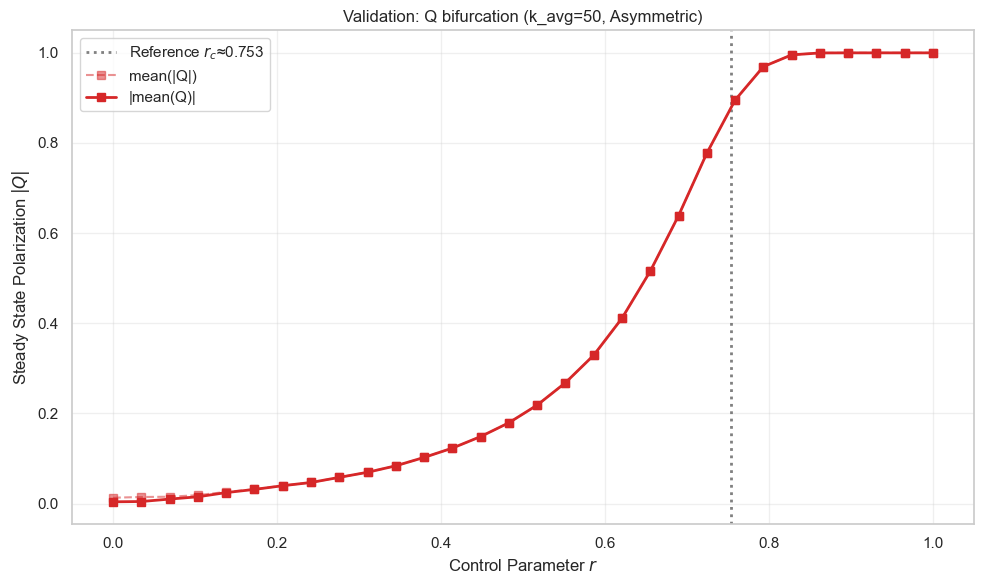

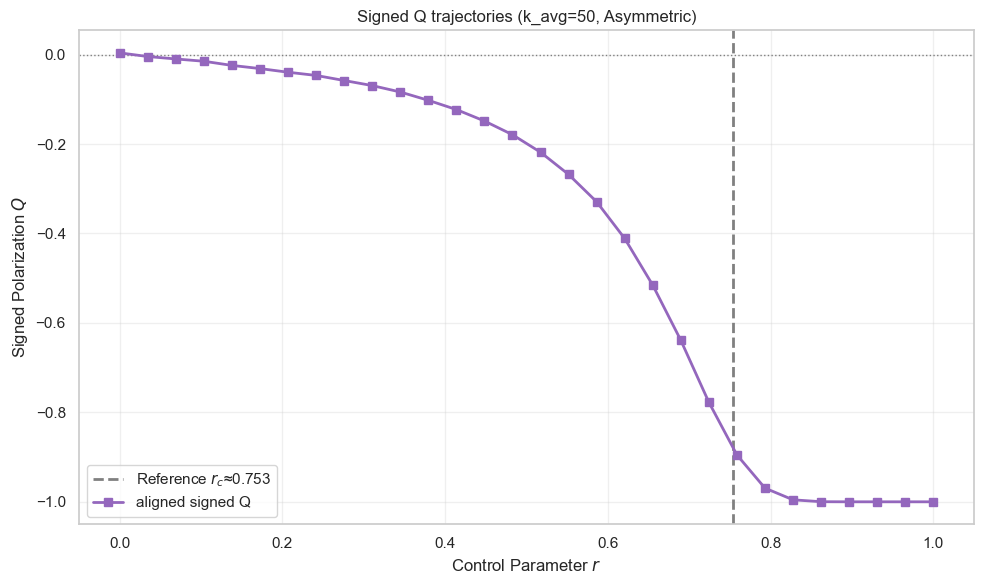

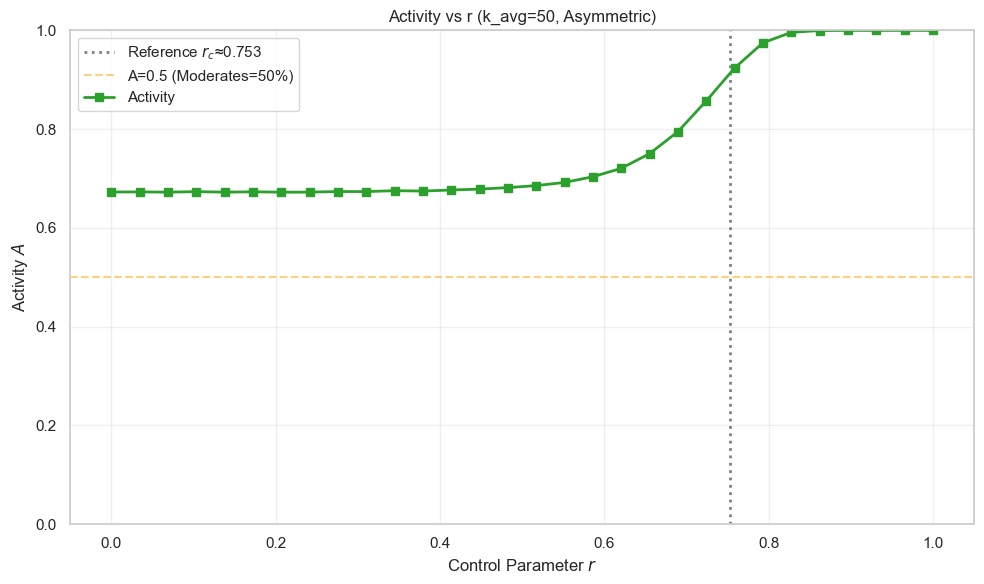

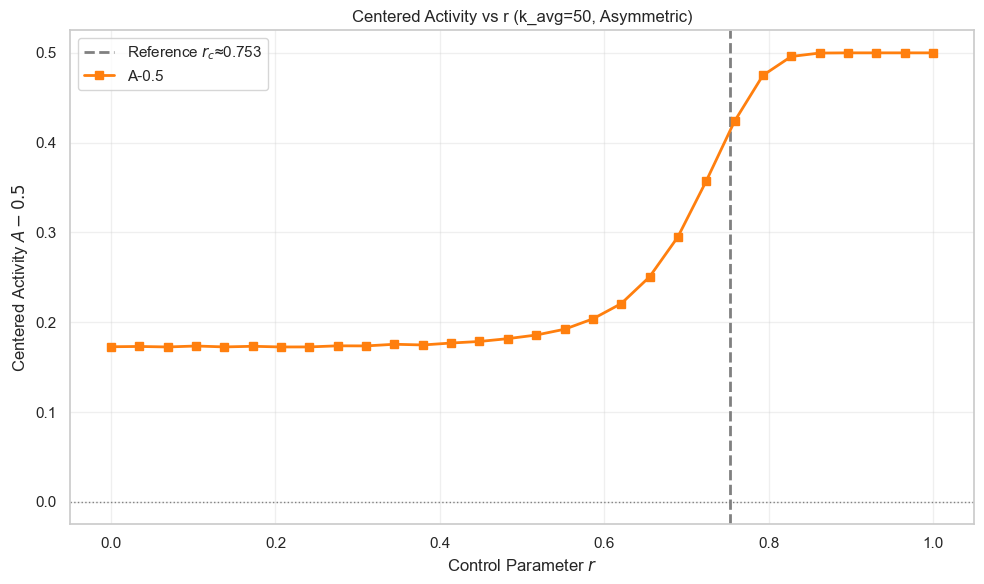

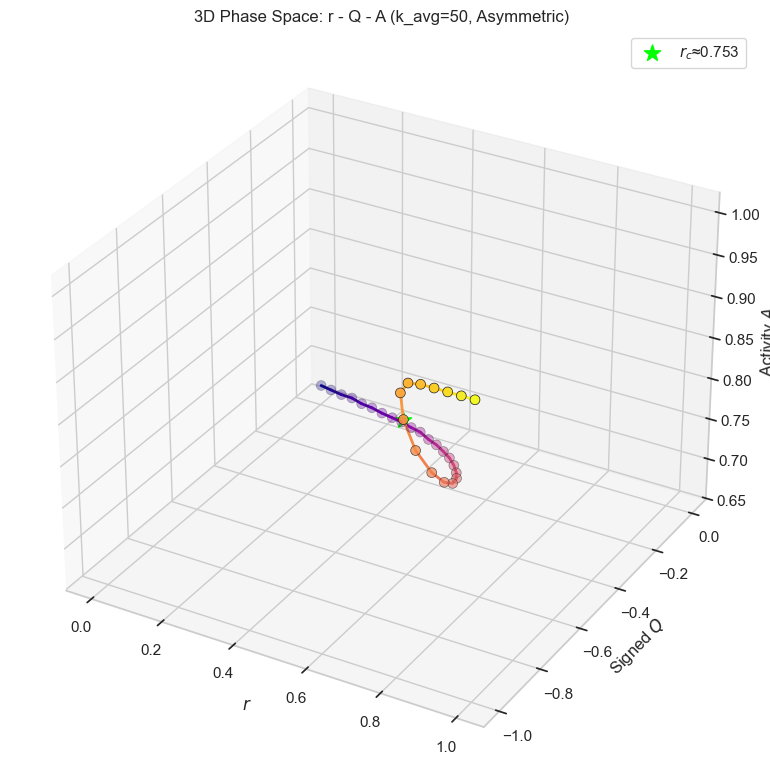

In [9]:
# 运行非对称模式（复用上一个 cell 的函数）
r_asym, res_asym = run_abm_scan(symmetric_mode=False, mode_tag="asym")
plot_abm_results(
    r_asym,
    res_asym,
    mode_tag="asym",
    title_tag="Asymmetric",
    color_main="tab:red",
    cmap="plasma",
    star_color="lime",
    theory_applicable=False,
)


## 附录：有限尺寸效应 (Finite-Size Scaling)

**目标**：检验随着系统规模 $N$ 增大，模拟估计的 $r_c(N)$ 是否趋近于理论 $r_c$。

**方案B（更严谨）**：用“易感性/涨落峰值”来估计 $r_c(N)$。

- 定义（类 Ising susceptibility）：
  $$\chi_{\mathrm{sim}}(r;N)=N\left(\langle Q^2\rangle-\langle |Q|\rangle^2\right)$$
  其中 $\langle\cdot\rangle$ 是稳态窗口内的时间平均。
- 对每个 $N$ 扫描 $r$，取 $\chi_{\mathrm{sim}}$ 的峰值位置作为 $r_c(N)$。

备注：该估计仍依赖 `steps / burn-in / record_interval / seeds`。临界附近弛豫变慢，若峰值不稳定，优先增加 `steps` 与 `seeds`。


In [ ]:
# 有限尺寸效应验证（方案B）：用 susceptibility 峰值估计 r_c(N)
# chi_sim(r;N) = N * ( <Q^2> - <|Q|>^2 )，峰值位置作为 rc_est(N)

k_avg = TARGET_SAMPLE_N

# 实验参数（可调）
N_list = [100, 200, 500, 1000, 2000]
seeds = list(range(8))

steps = 1200
record_interval = 5
burn_in_frac = 0.5
update_rate = 1.0  # beta=0 情况下可用同步更新以加速混合
init_state = "random"  # 用随机初态加速进入稳态（对称系统期望仍为 0）

# r 扫描：围绕理论 rc 扫一段区间
chi = theory.calculate_chi(phi, theta, k_avg=k_avg)
rc_theory = float(theory.calculate_rc(n_m, n_w, chi))
print(f"理论 rc = {rc_theory:.4f}")

r_span = 0.2
r_points = 31
r_min = max(0.0, rc_theory - r_span)
r_max = min(1.0, rc_theory + r_span)
r_scan_fs = np.linspace(r_min, r_max, r_points)

burn_step = steps * burn_in_frac

# cache（该 cell 计算量较大，建议缓存）
burn_tag = int(burn_in_frac * 100)
phi_tag = int(round(phi * 100))
theta_tag = int(round(theta * 100))
cache_name = (
    f"finite_size_chi_peak_sym_phi{phi_tag}_theta{theta_tag}_"
    f"nm{int(n_m)}_nw{int(n_w)}_k{k_avg}_"
    f"N{min(N_list)}-{max(N_list)}_"
    f"init{init_state}_u{int(update_rate*100)}_"
    f"ri{record_interval}_steps{steps}_burn{burn_tag}_"
    f"seeds{len(seeds)}_r{len(r_scan_fs)}_v2.npz"
)
cache_path = data_dir / cache_name


def susceptibility_from_q(q_window: np.ndarray, N: int) -> float:
    # 类 Ising susceptibility：N(<Q^2>-<|Q|>^2)，避免对称双峰导致的“伪大方差”
    q2 = float(np.mean(q_window**2))
    qabs = float(np.mean(np.abs(q_window)))
    return N * (q2 - qabs**2)


if cache_path.exists():
    loaded = np.load(cache_path, allow_pickle=False)
    N_list = loaded["N_list"].astype(int).tolist()
    r_scan_fs = loaded["r_scan"].astype(float)
    chi_mean_by_N = loaded["chi_mean_by_N"].astype(float)
    chi_sem_by_N = loaded["chi_sem_by_N"].astype(float)
    rc_peak_mean = loaded["rc_peak_mean"].astype(float)
    rc_peak_std = loaded["rc_peak_std"].astype(float)
    print(f"[finite-size] Loaded cache: {fmt_path(cache_path)}")
else:
    print(
        "[finite-size] Simulating susceptibility curves... "
        f"(seeds={len(seeds)}, steps={steps}, ri={record_interval}, burn={burn_in_frac})"
    )

    chi_mean_by_N = []
    chi_sem_by_N = []
    rc_peak_mean = []
    rc_peak_std = []

    for N in N_list:
        chi_seeds = np.zeros((len(seeds), len(r_scan_fs)), dtype=float)
        peak_r_seeds = np.zeros(len(seeds), dtype=float)

        for si, seed in enumerate(seeds):
            for ri, r in enumerate(r_scan_fs):
                cfg = NetworkConfig(
                    n=N,
                    avg_degree=min(k_avg, N - 1),
                    model="er",
                    beta=0.0,
                    update_rate=update_rate,
                    r=float(r),
                    n_m=n_m,
                    n_w=n_w,
                    phi=phi,
                    theta=theta,
                    seed=int(seed),
                    init_state=init_state,
                    sample_mode="fixed",
                    sample_n=min(k_avg, N - 1),
                    symmetric_mode=True,
                )
                model = NetworkAgentModel(cfg)
                t, q_traj, _ = model.run(steps=steps, record_interval=record_interval)
                steady_q = q_traj[t >= burn_step]
                chi_seeds[si, ri] = susceptibility_from_q(steady_q, N)

            peak_r_seeds[si] = float(r_scan_fs[int(np.argmax(chi_seeds[si]))])

        chi_mean = chi_seeds.mean(axis=0)
        chi_sem = chi_seeds.std(axis=0, ddof=1) / np.sqrt(len(seeds))

        chi_mean_by_N.append(chi_mean)
        chi_sem_by_N.append(chi_sem)
        rc_peak_mean.append(float(np.mean(peak_r_seeds)))
        rc_peak_std.append(float(np.std(peak_r_seeds, ddof=1)))

        print(f"N={N}: rc_peak ≈ {rc_peak_mean[-1]:.4f} ± {rc_peak_std[-1]:.4f} (seed-to-seed)")

    chi_mean_by_N = np.asarray(chi_mean_by_N, dtype=float)
    chi_sem_by_N = np.asarray(chi_sem_by_N, dtype=float)
    rc_peak_mean = np.asarray(rc_peak_mean, dtype=float)
    rc_peak_std = np.asarray(rc_peak_std, dtype=float)

    np.savez(
        cache_path,
        N_list=np.asarray(N_list, dtype=int),
        r_scan=r_scan_fs,
        chi_mean_by_N=chi_mean_by_N,
        chi_sem_by_N=chi_sem_by_N,
        rc_peak_mean=rc_peak_mean,
        rc_peak_std=rc_peak_std,
    )
    print(f"[finite-size] Saved cache: {fmt_path(cache_path)}")


# Plot 1: susceptibility curves
fig, ax = plt.subplots(figsize=(10, 6))
for i, N in enumerate(N_list):
    line = ax.plot(r_scan_fs, chi_mean_by_N[i], linewidth=2, label=f"N={N}")[0]
    color = line.get_color()
    ax.fill_between(
        r_scan_fs,
        chi_mean_by_N[i] - chi_sem_by_N[i],
        chi_mean_by_N[i] + chi_sem_by_N[i],
        color=color,
        alpha=0.15,
        linewidth=0,
    )
ax.axvline(rc_theory, color="gray", linestyle="--", linewidth=2, label=f"Theory rc={rc_theory:.3f}")
ax.set_xlabel("Control Parameter $r$")
ax.set_ylabel(r"$\chi_{sim}=N(\langle Q^2\rangle-\langle |Q|\rangle^2)$")
ax.set_title("Finite-Size Scaling: Susceptibility Peak")
ax.legend(ncol=2)
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

# Plot 2: rc(N) from susceptibility peak
fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(
    N_list,
    rc_peak_mean,
    yerr=rc_peak_std,
    fmt="o-",
    markersize=7,
    linewidth=2,
    capsize=3,
    label=r"Simulation (peak of $\chi_{sim}$)",
)
ax.axhline(rc_theory, color="red", linestyle="--", linewidth=2, label=f"Theory $r_c$={rc_theory:.3f}")
ax.set_xlabel("System size N")
ax.set_ylabel("Estimated $r_c(N)$")
ax.set_title("Finite-Size Scaling: $r_c(N)$")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale("log")
fig.tight_layout()
plt.show()

print(
    "提示：若 rc_peak(N) 不稳定或误差条很大，优先增加 steps / seeds；"
    "临界附近弛豫变慢，burn-in 也可能需要更长。"
)


理论 rc = 0.7533
[finite-size] Simulating susceptibility curves... (seeds=8, steps=1200, ri=5, burn=0.5)
N=100: rc_peak ≈ 0.7066 ± 0.0864 (seed-to-seed)
N=200: rc_peak ≈ 0.7083 ± 0.0834 (seed-to-seed)
N=500: rc_peak ≈ 0.6233 ± 0.0802 (seed-to-seed)
N=1000: rc_peak ≈ 0.6233 ± 0.0802 (seed-to-seed)
